
**Install requirements**

In [1]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

**Import libraries**

In [3]:
import os
import os.path
import sys
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.datasets import VisionDataset
from torchvision.models import alexnet
from torchvision.models import vgg16
from torchvision.models import resnext50_32x4d

from PIL import Image
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import operator

**Set Arguments**

In [4]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 64     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 15      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

SPLITTING_CHECK = False
COMPUTE_MEANS = False
IMAGE_VISUALIZATION = False
TEN_CROP_TEST = True
VISUALIZE_PREDICTIONS = False

**Define Data Preprocessing**

In [6]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomResizedCrop(224),
                                      #transforms.RandomHorizontalFlip(0.5),
                                      #transforms.RandomGrayscale(0.5),
                                      #transforms.RandomRotation((-90, 90)),
                                      #transforms.RandomVerticalFlip(0.5),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and std of ImageNet Database
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      #transforms.TenCrop(224),
                                      #transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      #transforms.Lambda(lambda crops: torch.stack([
                                      #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(crop) for crop in crops]))
                                      
])

**Caltech class**

In [7]:
# Clone github repository with data

if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension."""
    return filename.lower().endswith(extensions)

def is_image_file(filename):
    """Checks if a file is an allowed image extension."""
    
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)

def make_dataset(directory, class_to_idx, split, extensions=None, is_valid_file=None):
    instances = []
    split = split + ".txt"
    caltech_dir, objCat_dir = directory.split("/", 1)
    path = os.path.join(caltech_dir, split)
    path = os.path.expanduser(path)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)
    
    file = open(path, "r")
    for line in file:
        target_class, pic = line.split("/", 1)
        pic = pic.strip()
        if target_class == "BACKGROUND_Google":
            continue
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        target_file = os.path.join(target_dir, pic)
        target_file = os.path.expanduser(target_file)
        if is_valid_file(target_file):
            item = target_file, class_index
            instances.append(item)    
    
    return instances

class Caltech(VisionDataset):
    def __init__(self, root, split='train', loader=pil_loader, extensions=None, transform=None, target_transform=None, is_valid_file=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        ''' 
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, split, IMG_EXTENSIONS, is_valid_file)
        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.loader = loader
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir):
        
        """Finds the class folders in a dataset."""
        
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        classes.pop(0)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        image, label = self.samples[index] # Provide a way to access image and label via index
                                            # Image should be a PIL Image
                                            # label can be int
        sample = self.loader(image)
        # Applies preprocessing when accessing the image
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            label = self.target_transform(target)

        return sample, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples) # Provide a way to get the length (number of elements) of the dataset
        return length

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

class ImageFolder(Caltech):

    def __init__(self, root, transform=None, target_transform=None,
                 loader=pil_loader, is_valid_file=None):
        super(ImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 22.48 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.


**Prepare Dataset**

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

class_to_idx = train_dataset.class_to_idx
classes = train_dataset.classes

X = []
y = []

for image, label in train_dataset:
    X.append(image)
    y.append(label)

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=0)  

for train_index, val_index in sss.split(X, y):
    train_indexes = train_index # split the indices for your train split
    val_indexes = val_index # split the indices for your val split

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
print('Dataset size: {}'.format(len(train_dataset) + len(val_dataset) + len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893
Dataset size: 8677


**Images distribution among classes**

Top 10 classes in train split:
[('airplanes', 267), ('Motorbikes', 266), ('Faces', 145), ('Faces_easy', 145), ('watch', 79), ('Leopards', 66), ('bonsai', 42), ('car_side', 41), ('ketch', 38), ('chandelier', 36)]


Top 10 classes in validation split:
[('airplanes', 267), ('Motorbikes', 266), ('Faces', 145), ('Faces_easy', 145), ('watch', 80), ('Leopards', 67), ('bonsai', 43), ('car_side', 41), ('ketch', 38), ('chandelier', 36)]


Top 10 classes in test split:
[('Motorbikes', 266), ('airplanes', 266), ('Faces', 145), ('Faces_easy', 145), ('watch', 80), ('Leopards', 67), ('bonsai', 43), ('car_side', 41), ('ketch', 38), ('chandelier', 35)]




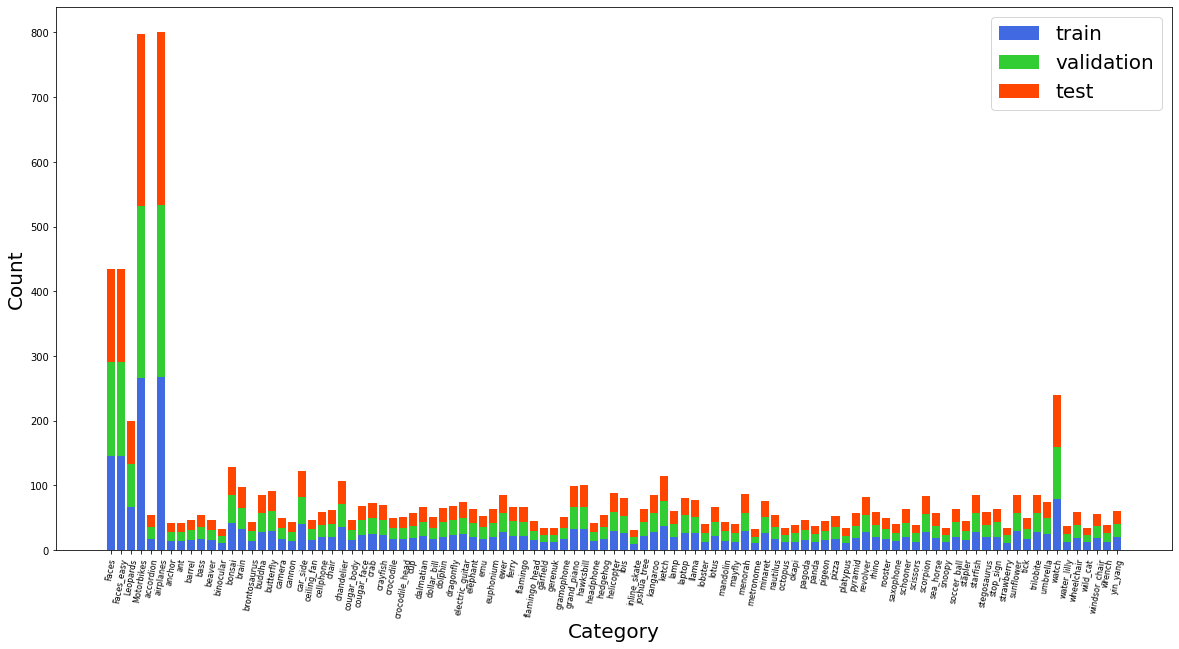

Top 10 classes in Caltech-101 dataset:
[('airplanes', 800), ('Motorbikes', 798), ('Faces', 435), ('Faces_easy', 435), ('watch', 239), ('Leopards', 200), ('bonsai', 128), ('car_side', 123), ('ketch', 114), ('chandelier', 107)]


Bottom 5 classes in Caltech-101 dataset:
[('platypus', 34), ('wild_cat', 34), ('binocular', 33), ('metronome', 32), ('inline_skate', 31)]


Bottom 5 classes in train split:
[('binocular', 11), ('metronome', 11), ('platypus', 11), ('strawberry', 11), ('inline_skate', 10)]


Bottom 5 classes in validation split:
[('inline_skate', 11), ('platypus', 11), ('snoopy', 11), ('wild_cat', 11), ('metronome', 10)]


Bottom 5 classes in test split:
[('gerenuk', 11), ('metronome', 11), ('octopus', 11), ('wild_cat', 11), ('inline_skate', 10)]




In [9]:
count_train_items = {}
count_val_items = {}
count_test_items = {}
count_total_items = {}

for c in classes:
  count_train_items[c] = 0
  count_val_items[c] = 0
  count_test_items[c] = 0

for image, label in train_dataset:
  i = classes[label]
  count_train_items[i] += 1

for image, label in val_dataset:
  i = classes[label]
  count_val_items[i] += 1

for image, label in test_dataset:
  i = classes[label]
  count_test_items[i] += 1

for c in classes:
  count_total_items[c] = count_train_items[c] + count_val_items[c] 

sorted_train_items = dict(sorted(count_train_items.items(), key=operator.itemgetter(1), reverse=True))
sorted_val_items = dict(sorted(count_val_items.items(), key=operator.itemgetter(1), reverse=True))
sorted_test_items = dict(sorted(count_test_items.items(), key=operator.itemgetter(1), reverse=True))
sorted_total_items = dict(sorted(count_total_items.items(), key=operator.itemgetter(1), reverse=True))

print("Top 10 classes in train split:")
print(list(sorted_train_items.items())[:10])
print("\n")

print("Top 10 classes in validation split:")
print(list(sorted_val_items.items())[:10])
print("\n")

print("Top 10 classes in test split:")
print(list(sorted_test_items.items())[:10])
print("\n")

index = np.arange(len(classes))
plt.figure(figsize=(20, 10))
p1 = plt.bar(index, count_train_items.values(), color='royalblue')
p2 = plt.bar(index, count_val_items.values(), bottom=list(count_train_items.values()), color='limegreen')
p3 = plt.bar(index, count_test_items.values(), bottom=list(count_total_items.values()), color='orangered')
plt.xlabel('Category', fontsize=20)
plt.ylabel('Count', fontsize=20)
#plt.title('Number of image by Category in Caltech-101', fontsize=30)
plt.xticks(index, classes, fontsize=8, rotation=80)
plt.legend((p1[0], p2[0], p3[0]), ('train', 'validation', 'test'), prop={'size': 20})
plt.show()

for c in classes:
  count_total_items[c] += count_test_items[c]

sorted_total_items_final = dict(sorted(count_total_items.items(), key=operator.itemgetter(1), reverse=True))

print("Top 10 classes in Caltech-101 dataset:")
print(list(sorted_total_items_final.items())[:10])
print("\n")

print("Bottom 5 classes in Caltech-101 dataset:")
print(list(sorted_total_items_final.items())[96:101])
print("\n")

print("Bottom 5 classes in train split:")
print(list(sorted_train_items.items())[96:101])
print("\n")

print("Bottom 5 classes in validation split:")
print(list(sorted_val_items.items())[96:101])
print("\n")

print("Bottom 5 classes in test split:")
print(list(sorted_test_items.items())[96:101])
print("\n")

**Test** **Splitting** **Check**

In [11]:
# Check if classes are distributed equally between training and validation set

if SPLITTING_CHECK:

  labels = []
  labels_val = []
  images = []
  images_val = []

  for image, label in train_dataset:
    labels.append(label)
    images.append(image)

  for image_val, label_val in val_dataset:
    labels_val.append(label_val)
    images_val.append(image_val)

  l = pd.Series(labels)
  l_val = pd.Series(labels_val)
  print(l.value_counts(sort=False).head())
  print(l_val.value_counts(sort=False).head())


**Compute means**

In [12]:
# Algorithm to compute effective means and standard deviation of Caltech 101 images
# It is not used

if COMPUTE_MEANS:

  means_1 = []
  means_2 = []
  means_3 = []
  stds_1 = []
  stds_2 = []
  stds_3 = []

  for img, lab in train_dataset:      # For test dataset Normalization iter on train_dataset
      means_1.append(torch.mean(img[0]))
      means_2.append(torch.mean(img[1]))
      means_3.append(torch.mean(img[2]))
      stds_1.append(img[0])
      stds_2.append(img[1])
      stds_3.append(img[2])

  stds_1 = torch.cat((stds_1), 0)
  stds_2 = torch.cat((stds_2), 0)
  stds_3 = torch.cat((stds_3), 0)
  mean_1 = torch.mean(torch.tensor(means_1))
  mean_2 = torch.mean(torch.tensor(means_2))
  mean_3 = torch.mean(torch.tensor(means_3))
  std_1 = torch.std(stds_1)
  std_2 = torch.std(stds_2)
  std_3 = torch.std(stds_3)

  print("Means = [{:.4f}, {:.4f}, {:.4f}]".format(mean_1.item(), mean_2.item(), mean_3.item()))
  print("Stds = [{:.4f}, {:.4f}, {:.4f}]".format(std_1.item(), std_2.item(), std_3.item()))

**Visualize a few images**

In [13]:
# It prints one image per class from training set

if IMAGE_VISUALIZATION:

  def imshow(inp, title=None):
      """Imshow for Tensor."""
      inp = inp.numpy().transpose((1, 2, 0))
      #mean = np.array([0.485, 0.456, 0.406]) # If transfer learning is used, apply ImageNet normalization
      #std = np.array([0.229, 0.224, 0.225])
      mean = np.array([0.5, 0.5, 0.5])
      std = np.array([0.5, 0.5, 0.5])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)
      if title is not None:
          plt.title(title)
      plt.pause(0.001)  # pause a bit so that plots are updated

  visited_class = set()
  # Get a batch of training data
  for inputs, cl in train_dataset:
    if cl not in visited_class:
      # Make a grid from batch
      out = torchvision.utils.make_grid(inputs)
      imshow(out, title=classes[cl])
      visited_class.add(cl)



**Prepare Dataloaders**

In [14]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4) #, drop_last=True)


**Prepare Network**

In [15]:
#net = alexnet() # Loading AlexNet model
net = alexnet(pretrained=True) #for better performances (AlexNet pre-trained on ImageNet dataset)
#net = resnext50_32x4d(pretrained=True)
#net = vgg16(pretrained=True)

# Freeze model weights
#for param in net.parameters():
#  param.requires_grad = False

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

# Change fully-connected layer on ResNeXt-50

#num_ftrs = net.fc.in_features                                              
#net.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Change last layer of VGG

#num_ftrs = net.classifier[6].in_features
#net.classifier[6] = nn.Linear(num_ftrs, NUM_CLASSES)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


**Prepare Training**

In [16]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
#parameters_to_optimize = net.features.parameters() # In this case we optimize over the convolutional layer the parameters of AlexNet
#parameters_to_optimize = net.classifier.parameters() # In this case we optimize over the FC layer parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
#optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Visualization** **Function**

In [17]:
# Functions to plot training results 

import numpy as np
import matplotlib.pyplot as plt

def plot_loss(loss_train, loss_val):
  epochs = range(NUM_EPOCHS)
  loss_train = np.array(loss_train)
  loss_val = np.array(loss_val)
  plt.plot(epochs, loss_train, linestyle='-', color='b', label='Training loss')
  plt.plot(epochs, loss_val, linestyle='-', color='darkorange',label='Validation loss')
  plt.title('Training and Validation loss', fontsize=15, fontweight='bold')
  plt.xlabel('Epochs', fontsize=10, labelpad=7)
  plt.ylabel('Loss', fontsize=10, labelpad=10)
  plt.legend()
  plt.grid()
  plt.show()

def plot_accuracy(acc_train, acc_val):
  epochs = range(NUM_EPOCHS)
  acc_train = np.array(acc_train)
  acc_val = np.array(acc_val)
  plt.plot(epochs, acc_train, linestyle='-', color='b', label='Training accuracy')
  plt.plot(epochs, acc_val, linestyle='-', color='darkorange',label='Validation accuracy')
  plt.title('Training and Validation accuracy', fontsize=15, fontweight='bold')
  plt.xlabel('Epochs', fontsize=10, labelpad=7)
  plt.ylabel('Accuracy', fontsize=10, labelpad=10)
  plt.legend()
  plt.grid()
  plt.show()

**Train** **and Validation**

In [18]:
since = time.time()

print("Current Hyperparameters:")
print(f"Epochs = {NUM_EPOCHS}")
print(f"  Scheduler:")
print(f"  - Step Size = {STEP_SIZE}")
print(f"  - Gamma = {GAMMA}")
print(f"Optimizer: {optimizer}")
print(f"Device: {DEVICE}")
print()

train_loss = []
val_loss = []
train_acc = []
val_acc = []

best_net = copy.deepcopy(net.state_dict())
best_val_acc = 0.0

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  net.train() # Sets module in training mode

  running_loss = 0.0
  running_corrects = 0

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    with torch.set_grad_enabled(True):

      # Forward pass to the network
      outputs = net(images)

      _, preds = torch.max(outputs, 1)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients
      
    current_step += 1

    # statistics
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data).data.item() 
  
  epoch_loss = running_loss / float(len(train_dataloader)*BATCH_SIZE)
  epoch_acc = running_corrects / float(len(train_dataloader)*BATCH_SIZE)

  train_loss.append(epoch_loss) # loss computed as the average on mini-batches
  #train_loss.append(loss) # loss computed only on the last batch
  train_acc.append(epoch_acc)

  print('Train -> Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

  ### Start Validation phase

  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_val_loss = 0.0
  running_val_corrects = 0

  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Calculate Loss
      loss = criterion(outputs.data, labels)

    # Update Corrects and Loss
    running_val_loss += loss.item() * images.size(0)
    running_val_corrects += torch.sum(preds == labels.data)

  epoch_val_loss = running_val_loss / float(len(val_dataset))
  epoch_val_acc = running_val_corrects / float(len(val_dataset))

  val_loss.append(epoch_val_loss)
  val_acc.append(epoch_val_acc)

  print('Validation -> Loss: {:.4f} Acc: {:.4f}'.format(epoch_val_loss, epoch_val_acc))

  # deep copy the model
  if epoch_val_acc > best_val_acc:
    best_val_acc = epoch_val_acc
    #best_net = copy.deepcopy(net.state_dict())

  # Calculate Accuracy
  accuracy = running_val_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))

  # Step the scheduler
  scheduler.step()

  print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_val_acc))

# load best model weights

#net.load_state_dict(best_net)

Current Hyperparameters:
Epochs = 15
  Scheduler:
  - Step Size = 5
  - Gamma = 0.1
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.01
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)
Device: cuda

Starting epoch 1/15, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 5.013311386108398
Step 10, Loss 2.264331340789795
Step 20, Loss 1.5707478523254395
Step 30, Loss 1.1919217109680176
Step 40, Loss 1.2554889917373657
Train -> Loss: 2.1023 Acc: 0.5240
Validation -> Loss: 1.2797 Acc: 0.6763
Validation Accuracy: 0.6763485670089722

Starting epoch 2/15, LR = [0.01]
Step 50, Loss 0.9656305313110352
Step 60, Loss 0.7344257235527039
Step 70, Loss 0.9557844400405884
Step 80, Loss 0.8427998423576355
Train -> Loss: 0.9570 Acc: 0.7493
Validation -> Loss: 1.0859 Acc: 0.7279
Validation Accuracy: 0.727869987487793

Starting epoch 3/15, LR = [0.01]
Step 90, Loss 0.37054842710494995
Step 100, Loss 0.42806169390678406
Step 110, Loss 0.5502152442932129
Step 120, Loss 0.8133133053779602
Step 130, Loss 0.9872580766677856
Train -> Loss: 0.5968 Acc: 0.8389
Validation -> Loss: 1.0413 Acc: 0.7424
Validation Accuracy: 0.7423928380012512

Starting epoch 4/15, LR = [0.01]
Step 140, Loss 0.3339095115661621
Step 150, Loss 0.30396568775177
Step 160, Loss 0.730756521224

**Plot Loss**

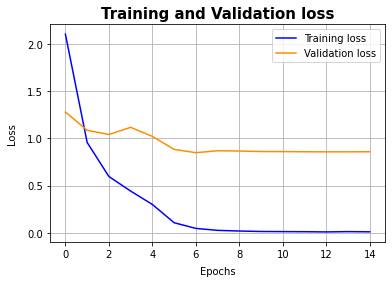

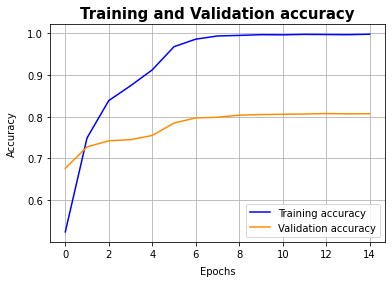

In [19]:
plot_loss(train_loss, val_loss)
plot_accuracy(train_acc, val_acc)

**Test**

In [20]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 46/46 [00:13<00:00,  3.36it/s]

Test Accuracy: 0.8216384376080194


In [ ]:
# Test with Ten Crop transformation

if TEN_CROP_TEST:

  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_test_loss = 0
  running_test_corrects = 0

  for images, labels in test_dataloader:

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    #images = torch.autograd.Variable(images, volatile=True)
    #labels = torch.autograd.Variable(labels, volatile=True)
    optimizer.zero_grad()

    with torch.no_grad():

      bs, ncrops, c, h, w = images.size()

      result = net(images.view(-1, c, h, w)) # fuse batch size and ncrops

      result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops

      _, preds = torch.max(result_avg.data, 1)

      test_loss = criterion(result_avg, labels)

    running_test_loss += loss.item() * images.size(0)
    running_test_corrects += torch.sum(preds == labels.data).data.item()  
    
    # Calculate Accuracy
  test_accuracy = running_test_corrects / float(len(test_dataset))
  test_loss = running_test_loss / float(len(test_dataset))
  print('Test Accuracy: {}'.format(accuracy))
  print('Test Loss: {}'.format(test_loss))

**Visualizing the model predictions**

In [23]:
if VISUALIZE_PREDICTIONS:

  def imshow(inp, title=None):
      """Imshow for Tensor."""
      inp = inp.numpy().transpose((1, 2, 0))
      #mean = np.array([0.485, 0.456, 0.406])
      #std = np.array([0.229, 0.224, 0.225])
      mean = np.array([0.5, 0.5, 0.5])
      std = np.array([0.5, 0.5, 0.5])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)
      if title is not None:
          plt.title(title)
      plt.pause(0.001)  # pause a bit so that plots are updated


  def visualize_model(model, num_images=6):
      was_training = model.training
      model.eval()
      images_so_far = 0
      fig = plt.figure()

      with torch.no_grad():
          for i, (inputs, labels) in enumerate(val_dataloader):
              inputs = inputs.to(DEVICE)
              labels = labels.to(DEVICE)

              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)

              for j in range(inputs.size()[0]):
                  images_so_far += 1
                  ax = plt.subplot(num_images//2, 2, images_so_far)
                  ax.axis('off')
                  ax.set_title('predicted: {}'.format(classes[preds[j]]))
                  imshow(inputs.cpu().data[j])

                  if images_so_far == num_images:
                      model.train(mode=was_training)
                      return
          model.train(mode=was_training)

In [22]:
if VISUALIZE_PREDICTIONS:

  visualize_model(net, 4)